In [3]:
import h5py
import tensorflow as tf
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

In [4]:
hdf5_file = "energy_data.h5"
test_hdf5_file = "angle_data.h5"

In [63]:
p=0.1
class_coeff=[1.149,0.783]

In [65]:
# Define the generator function
def hdf5_generator(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    args=[hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)


print("Train data loaded")

def test_hdf5_generator(hdf5_file):
    with h5py.File(test_hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
test_dataset = tf.data.Dataset.from_generator(
    test_hdf5_generator,
    args=[test_hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)

print("Validation and test data loaded")
with h5py.File(hdf5_file, "r") as hdf:
    dataset_size = len(hdf["data"])  # Or hdf["labels"], if they have the same length
    print(f"Dataset size: {dataset_size}")
train_dataset=dataset.take(int(0.8*dataset_size*p))
train_dataset=train_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset=test_dataset.take(int(int(0.3*dataset_size*p)))
val_dataset=val_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds=test_dataset.skip(int(int(0.3*dataset_size*p))).take(int(int(0.1*dataset_size*p)))
test_ds=test_ds.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds2=dataset.skip(int(0.8*dataset_size*p)).take(int(0.2*dataset_size*p))
test_ds2=test_ds2.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
print("Dane treningowe, walidacyjne i testowe ready")

input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')
summed_tensor = Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2, 3, 4]))(input_3d)  # Sum over spatial dimensions
summed_tensor_expanded = Lambda(lambda t: tf.expand_dims(t, axis=-1))(summed_tensor)  # Expand to (None, 1)
output = (summed_tensor_expanded/10-class_coeff[1])/class_coeff[0]
klasyka = Model(inputs=[input_3d], outputs=output)
klasyka.compile(
    optimizer='adam',              # Optimizer (doesn't matter since no parameters to optimize)
    loss='mean_squared_error',     # Loss function (again, won't affect the result)
    metrics=['mae']                # Metric (useful to track performance)
)

print("Klasyka dla wybranych danych:")
class_loss_ang, class_mae_ang = klasyka.evaluate(test_ds)
print("Kątowe MAE klasycznego zliczania:", class_mae_ang)
class_loss_base, class_mae_base = klasyka.evaluate(test_ds2)
print("Bazowe MAE klasycznego zliczania:", class_mae_base)

cE_pred=klasyka.predict(test_ds).flatten()
cE_true = np.array([label.numpy() for _, label in test_ds]).flatten()
cE_pred2=klasyka.predict(test_ds2).flatten()
cE_true2 = np.array([label.numpy() for _, label in test_ds2]).flatten()
cE_true=np.concatenate((cE_true,cE_true2),axis=0)
cE_pred=np.concatenate((cE_pred,cE_pred2),axis=0)
class_error=np.abs(cE_true-cE_pred)
print("Wygenerowane dane z pomiarów klasycznych")

Train data loaded
Validation and test data loaded
Dataset size: 450000
Dane treningowe, walidacyjne i testowe ready
Klasyka dla wybranych danych:
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 36.7317 - mae: 4.6013
Kątowe MAE klasycznego zliczania: 4.533822536468506
281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - loss: 58.6629 - mae: 5.5639
Bazowe MAE klasycznego zliczania: 5.458462715148926
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step
Wygenerowane dane z pomiarów klasycznych


In [66]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,                 # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

In [67]:
#Tu zdefiniuj model
input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')

# 3D CNN Path
x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_3d) 
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(x) 
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same')(x) 
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten 3D features
x = layers.Flatten()(x)

summed_tensor = Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2, 3, 4]))(input_3d)  # Sum over spatial dimensions
summed_tensor_expanded = Lambda(lambda t: tf.expand_dims(t, axis=-1))(summed_tensor)  # Expand to (None, 1)
summed_tensor_exp = (summed_tensor_expanded/10-class_coeff[1])/class_coeff[0]
# Ensure shapes are compatible for concatenation
combined = layers.Concatenate(axis=-1)([x, summed_tensor_exp, summed_tensor_expanded])  # Concatenate along last axis

# Fully Connected Layers
fc = layers.Dense(64, activation='relu')(combined)
fc = layers.Dense(32, activation='relu')(fc)

# Output Layer
output = layers.Dense(1, activation='linear')(fc)

# Define the Model
model = Model(inputs=[input_3d], outputs=output)

# Compile the Model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])     

In [68]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True);

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 3D_Input            │ (None, 20, 110,   │          0 │ -                 │
│ (InputLayer)        │ 11, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_11 (Conv3D)  │ (None, 20, 110,   │      1,792 │ 3D_Input[0][0]    │
│                     │ 11, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_11    │ (None, 10, 55, 5, │          0 │ conv3d_11[0][0]   │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_12 (Conv3D)  │ (None, 10, 55, 5, │     55,328 │ max_pooling3d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None)            │          0 │ 3D_Input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 5, 27, 2,  │          0 │ conv3d_12[0][0]   │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_25 (Lambda)  │ (None, 1)         │          0 │ lambda_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_13 (Conv3D)  │ (None, 5, 27, 2,  │     13,840 │ max_pooling3d_12… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_21      │ (None, 1)         │          0 │ lambda_25[0][0]   │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_13    │ (None, 2, 13, 1,  │          0 │ conv3d_13[0][0]   │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_10         │ (None, 1)         │          0 │ true_divide_21[0… │
│ (Subtract)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 416)       │          0 │ max_pooling3d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_22      │ (None, 1)         │          0 │ subtract_10[0][0] │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 418)       │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ true_divide_22[0… │
│                     │                   │            │ lambda_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     26,816 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      2,080 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,889 (390.19 KB)

 Trainable params: 99,889 (390.19 KB)

 Non-trainable params: 0 (0.00 B)

Podaj nazwę modelu: 3CM[64,32,16]+E+E^+2D


Epoch 1/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 488s 432ms/step - loss: 283.2929 - mean_absolute_error: 8.0873 - val_loss: 36.9497 - val_mean_absolute_error: 4.6211
Epoch 2/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 475s 423ms/step - loss: 49.6948 - mean_absolute_error: 5.3469 - val_loss: 35.5120 - val_mean_absolute_error: 4.5311
Epoch 3/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 445s 395ms/step - loss: 47.6555 - mean_absolute_error: 5.2291 - val_loss: 32.0512 - val_mean_absolute_error: 4.2881
Epoch 4/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 536s 476ms/step - loss: 44.4052 - mean_absolute_error: 5.0517 - val_loss: 30.9866 - val_mean_absolute_error: 4.1971
Epoch 5/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 459s 408ms/step - loss: 42.1910 - mean_absolute_error: 4.9340 - val_loss: 30.6046 - val_mean_absolute_error: 4.1850
Epoch 6/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 442s 393ms/step - loss: 40.3490 - mean_absolute_error: 4.8373 - val_loss: 30.8955 - val_mean_absolute_error: 4.2503
Epoch 7/20
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 438s 389m

C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\2795866252.py:33: RuntimeWarning: Mean of empty slice.
  mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]
C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\2795866252.py:34: RuntimeWarning: Mean of empty slice.
  mean_error2 = [error2[bin_indices == i].mean() for i in range(1, num_bins)]  # Mean raw error
C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\2795866252.py:35: RuntimeWarning: Mean of empty slice.
  mean_class_error = [class_error[bin_indices == i].mean() for i in range(1, num_bins)]


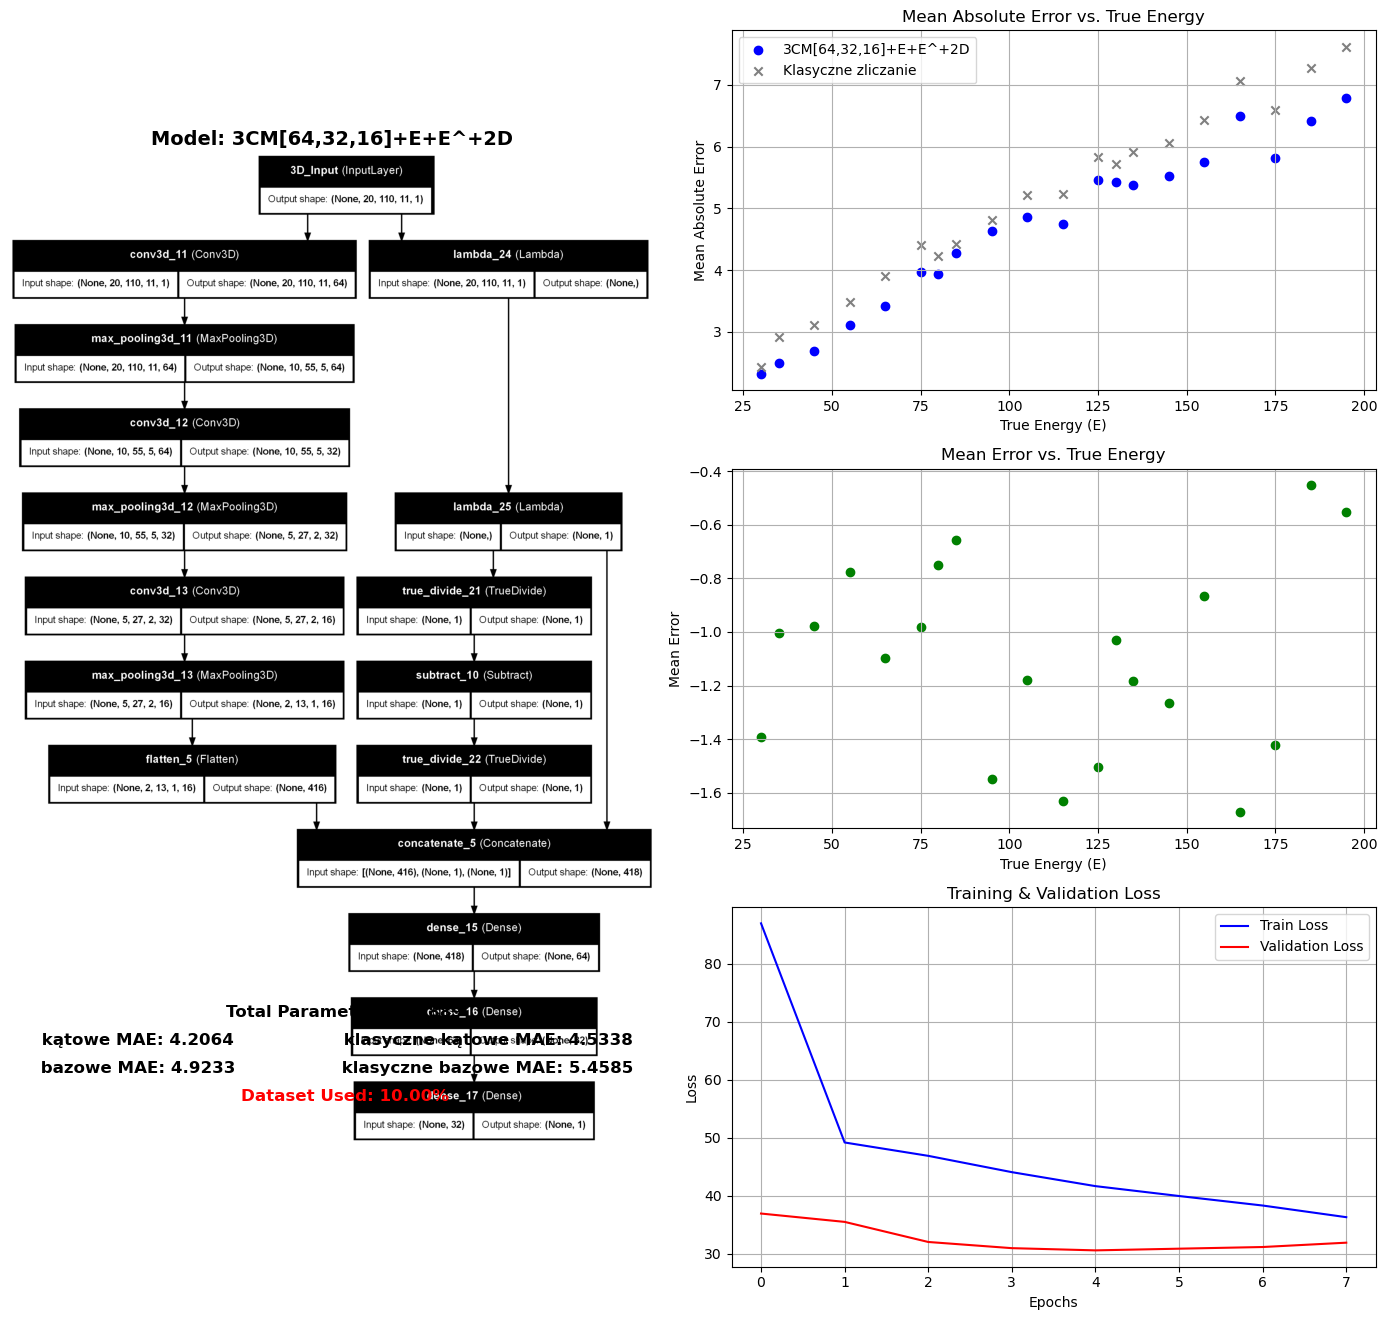

In [69]:
#Trening
model_name=input("Podaj nazwę modelu:")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,                 # Set a high number of epochs; EarlyStopping will stop early
    callbacks=[early_stopping],  # Add EarlyStopping to callbacks
    verbose=1
)
print("Wytrenowane!")
test_loss_ang, test_mae_ang = model.evaluate(test_ds)
print("Kątowe MAE dla sieci:", test_mae_ang)
test_loss_base, test_mae_base = model.evaluate(test_ds2)
print("Bazowe MAE dla sieci:", test_mae_base)

y_pred=model.predict(test_ds).flatten()
y_true = np.array([label.numpy() for _, label in test_ds]).flatten()
y_pred2=model.predict(test_ds2).flatten()
y_true2 = np.array([label.numpy() for _, label in test_ds2]).flatten()
y_true=np.concatenate((y_true,y_true2),axis=0)
y_pred=np.concatenate((y_pred,y_pred2),axis=0)

print("Inicjalizacja Grafiki")
model_img = mpimg.imread('model.png')
infographic_filename = f"{model_name}_infographic.png"
# --- Step 2: Compute Mean Absolute Error vs. True Energy ---
error = np.abs(y_true - y_pred)
error2 = y_true - y_pred  # Raw error\
num_bins = 36
bins = np.linspace(y_true.min(), y_true.max(), num_bins)
bin_indices = np.digitize(y_true, bins)
mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]
mean_error2 = [error2[bin_indices == i].mean() for i in range(1, num_bins)]  # Mean raw error
mean_class_error = [class_error[bin_indices == i].mean() for i in range(1, num_bins)]
# Total Parameters
total_params = model.count_params()
# --- Step 4: Create Infographic Layout ---
fig = plt.figure(figsize=(14, 14))  # Increased figure height to fit an extra row

# Create a 3-row, 2-column grid
grid_spec = fig.add_gridspec(3, 2, width_ratios=[1, 1])  

# --- Column 1 (Left) - Model Diagram (Spanning all three rows) ---
ax1 = fig.add_subplot(grid_spec[:, 0])
ax1.imshow(model_img)
ax1.axis('off')
ax1.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold')

# --- Column 2, Row 1 - MAE vs True Energy ---
ax2 = fig.add_subplot(grid_spec[0, 1])
ax2.scatter(bins[1:], mean_error, marker='o', color='blue', label=model_name)
ax2.scatter(bins[1:], mean_class_error, marker='x', color='grey', label='Klasyczne zliczanie') 
ax2.set_xlabel("True Energy (E)")
ax2.set_ylabel("Mean Absolute Error")
ax2.set_title("Mean Absolute Error vs. True Energy", fontsize=12)
ax2.grid(True)
ax2.legend()  # Add the legend

# --- Column 2, Row 2 - Raw Error vs True Energy ---
ax4 = fig.add_subplot(grid_spec[1, 1])  # New subplot for error2
ax4.scatter(bins[1:], mean_error2, marker='o', color='green')
ax4.set_xlabel("True Energy (E)")
ax4.set_ylabel("Mean Error")
ax4.set_title("Mean Error vs. True Energy", fontsize=12)
ax4.grid(True)

# --- Column 2, Row 3 - Training & Validation Loss ---
ax3 = fig.add_subplot(grid_spec[2, 1])
ax3.plot(history.history['loss'], label='Train Loss', color='blue')
ax3.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")
ax3.set_title("Training & Validation Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

# --- Step 5: Add Captions ---
fig.text(0.4, 0.05, f" kątowe MAE: {test_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.4, 0.03, f" bazowe MAE: {test_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.6, 0.05, f" klasyczne kątowe MAE: {class_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.6, 0.03, f" klasyczne bazowe MAE: {class_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
if p < 5:
    fig.text(0.5, 0.01, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold', color='red')
else:
    fig.text(0.5, 0.01, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Add Model Summary and Total Parameters ---
fig.text(0.5, 0.07, f"Total Parameters: {total_params:,}", ha='center', fontsize=12, fontweight='bold')

# --- Save or Show Infographic ---
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit captions
plt.savefig(infographic_filename, dpi=300)
plt.show()

C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\3590879181.py:9: RuntimeWarning: Mean of empty slice.
  mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]
C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\3590879181.py:10: RuntimeWarning: Mean of empty slice.
  mean_error2 = [error2[bin_indices == i].mean() for i in range(1, num_bins)]  # Mean raw error
C:\Users\spbki\AppData\Local\Temp\ipykernel_8660\3590879181.py:11: RuntimeWarning: Mean of empty slice.
  mean_class_error = [class_error[bin_indices == i].mean() for i in range(1, num_bins)]


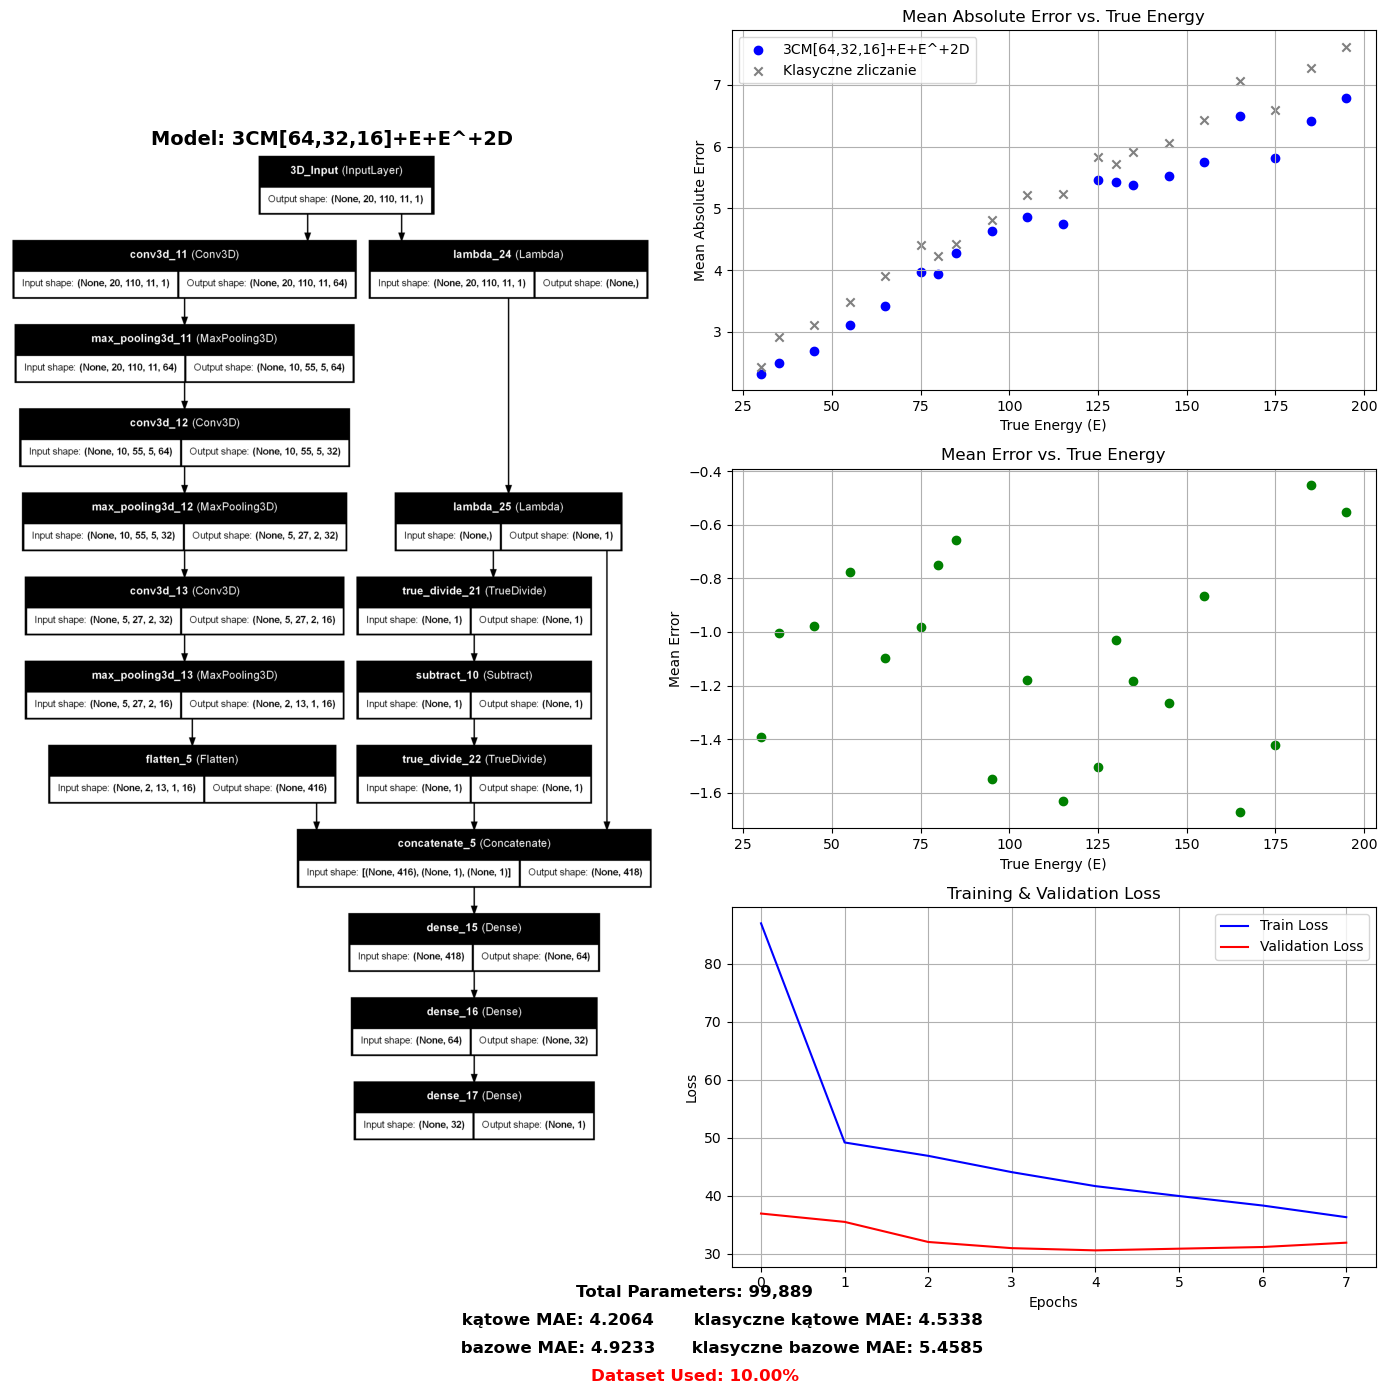

In [75]:
model_img = mpimg.imread('model.png')
infographic_filename = f"{model_name}_infographic.png"
# --- Step 2: Compute Mean Absolute Error vs. True Energy ---
error = np.abs(y_true - y_pred)
error2 = y_true - y_pred  # Raw error\
num_bins = 36
bins = np.linspace(y_true.min(), y_true.max(), num_bins)
bin_indices = np.digitize(y_true, bins)
mean_error = [error[bin_indices == i].mean() for i in range(1, num_bins)]
mean_error2 = [error2[bin_indices == i].mean() for i in range(1, num_bins)]  # Mean raw error
mean_class_error = [class_error[bin_indices == i].mean() for i in range(1, num_bins)]
# Total Parameters
total_params = model.count_params()

# --- Step 4: Create Infographic Layout ---
fig = plt.figure(figsize=(14, 14))  # Increased figure height to fit an extra row

# Create a 3-row, 2-column grid
grid_spec = fig.add_gridspec(3, 2, width_ratios=[1, 1])  

# --- Column 1 (Left) - Model Diagram (Spanning all three rows) ---
ax1 = fig.add_subplot(grid_spec[:, 0])
ax1.imshow(model_img)
ax1.axis('off')
ax1.set_title(f"Model: {model_name}", fontsize=14, fontweight='bold')

# --- Column 2, Row 1 - MAE vs True Energy ---
ax2 = fig.add_subplot(grid_spec[0, 1])
ax2.scatter(bins[1:], mean_error, marker='o', color='blue', label=model_name)
ax2.scatter(bins[1:], mean_class_error, marker='x', color='grey', label='Klasyczne zliczanie') 
ax2.set_xlabel("True Energy (E)")
ax2.set_ylabel("Mean Absolute Error")
ax2.set_title("Mean Absolute Error vs. True Energy", fontsize=12)
ax2.grid(True)
ax2.legend()  # Add the legend

# --- Column 2, Row 2 - Raw Error vs True Energy ---
ax4 = fig.add_subplot(grid_spec[1, 1])  # New subplot for error2
ax4.scatter(bins[1:], mean_error2, marker='o', color='green')
ax4.set_xlabel("True Energy (E)")
ax4.set_ylabel("Mean Error")
ax4.set_title("Mean Error vs. True Energy", fontsize=12)
ax4.grid(True)

# --- Column 2, Row 3 - Training & Validation Loss ---
ax3 = fig.add_subplot(grid_spec[2, 1])
ax3.plot(history.history['loss'], label='Train Loss', color='blue')
ax3.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss")
ax3.set_title("Training & Validation Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

# --- Step 5: Add Captions ---
fig.text(0.4, 0.05, f" kątowe MAE: {test_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.4, 0.03, f" bazowe MAE: {test_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.6, 0.05, f" klasyczne kątowe MAE: {class_mae_ang:.4f}", ha='center', fontsize=12, fontweight='bold')
fig.text(0.6, 0.03, f" klasyczne bazowe MAE: {class_mae_base:.4f}", ha='center', fontsize=12, fontweight='bold')
if p < 5:
    fig.text(0.5, 0.01, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold', color='red')
else:
    fig.text(0.5, 0.01, f"Dataset Used: {100*p:.2f}%", ha='center', fontsize=12, fontweight='bold')

# --- Add Model Summary and Total Parameters ---
fig.text(0.5, 0.07, f"Total Parameters: {total_params:,}", ha='center', fontsize=12, fontweight='bold')

# --- Save or Show Infographic ---
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to fit captions
plt.savefig(infographic_filename, dpi=300)
plt.show()